<a href="https://colab.research.google.com/github/dbabrams/MasonCounty/blob/master/CoLabTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install pyproj
!pip install rasterio
!pip install flopy

     |████████████████████████████████| 1.1MB 4.7MB/s 
  Created wheel for flopy: filename=flopy-3.3.0-cp36-none-any.whl size=1038572 sha256=376f13ee323480d1c1f1ebc7951f33dd7f48ab6cd7b67e8c1cfe1d2e87335d6b
  Stored in directory: /root/.cache/pip/wheels/d6/af/5a/6d32a03da175b47d8f8cca93b4d363a864cf604164b85af785
Successfully built flopy


In [11]:
import rasterio 
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import flopy
import matplotlib as mp
import pandas as pd
import pyproj

flopy is installed in /usr/local/lib/python3.6/dist-packages/flopy


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1vQgYEh41Cpx_XcsYnsnsh8zLb6j9RCRy"})   # replace the id with id of file you want to access
downloaded.GetContentFile('dem_ill.tif')

downloaded = drive.CreateFile({'id':"1JsAiGG4RvcfYrQtfgXRW9ZVfAkQ1yRVu"})
downloaded.GetContentFile('rivers_625.csv')

downloaded = drive.CreateFile({'id':"16eir18AG3Z3CNMxvXG8ZX9HmLnVZ67u5"})
downloaded.GetContentFile('mf2005.exe')

In [0]:
'''Create a MODFLOW model object and run with MODFLOW 2005.'''
#----------------------------------------------------------------------------
modelname = "my_model"
m = flopy.modflow.Modflow(modelname, exe_name = 'mf2005')
#----------------------------------------------------------------------------

In [53]:
#----------------------------------------------------------------------------
# Define model domain in lat/long coordinates
sw_lat =  40.045872 #southwest latitude
sw_long = -90.397402 #southwest longitude
ne_lat =  40.575944 #northeast latitude
ne_long = -89.587339 #northeast longitude

illimap = {'proj': 'lcc', # Lambert Conformal Conic
     'ellps': 'clrk66',
     'lon_0': -89.5,
     'lat_0': 33,
     'lat_1': 33,
     'lat_2': 45,
     'x_0': 2999994*0.3048,
     'y_0': 0}

prj = pyproj.Proj(illimap)

wgs84 = pyproj.Proj("epsg:4326")

nex, ney = pyproj.transform(wgs84,illimap,ne_lat,ne_long)
swx, swy = pyproj.transform(wgs84,illimap,sw_lat,sw_long)

nex, ney = round(nex/0.3048,-4), round(ney/0.3048,-4)
swx, swy = round(swx/0.3048,-4), round(swy/0.3048,-4)
print(nex,ney,swx,swy)

# Assign Discretization variables
Lx = nex-swx # Width of the model domain
Ly = ney-swy # Height of the model domain
ztop = 0. # Model top elevation
zbot = -50. # Model bottom elevation
nlay = 1 # Number of model layers
dx = 1000
dy = 1000
nrow = int(Ly/dy) # Number of rows
ncol = int(Lx/dx) # Number of columns

nper = 1 #specify number of stress periods
steady = [True] #specify if stress period is transient or steady-state

# create flopy discretization object
# length and time are feet (1) and days (4).
# See https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm 
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 1, 
                               nper=nper, steady=steady)

2980000.0 2750000.0 2750000.0 2560000.0
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


In [54]:
'''Create the Basic Package, which contains ibound and starting heads'''
#----------------------------------------------------------------------------
# Create ibound as array of ints (1), indicating all cells are active
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

# Create starting head array, must be floats.
strt = 5*np.ones((nlay, nrow, ncol), dtype=np.float32) #set every cell to 5.0

#Create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)
#----------------------------------------------------------------------------

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


In [55]:
'''Create the Layer Property Flow Package, which contains information about
hydruaulic conductivity and other information about how to calculate flow'''

hk = np.ones((nlay,nrow,ncol), dtype=np.float32) #define horizontal hydraulic conductivity
vk = np.ones((nlay,nrow,ncol), dtype=np.float32) #define vertical hydraulic conductivity

#define layer type as convertible (1), must be an integer
#for more information, see https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm
laytyp = np.ones((nlay,), dtype=np.int32)

# create the LPF object
lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vk, laytyp=laytyp, ipakcb=1)


****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...


In [56]:


rch = flopy.modflow.mfrch.ModflowRch(model=m,rech = 0.00001)


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...


In [57]:
# import stage, lambert x, lambert y
dfriv = pd.read_csv('rivers_625.csv')

# trim dataframe with river information to the model domain
dfriv = dfriv.loc[dfriv['lamx']<nex]
dfriv = dfriv.loc[dfriv['lamy']<ney]
dfriv = dfriv.loc[dfriv['lamx']>swx]
dfriv = dfriv.loc[dfriv['lamy']>swy]

# assign all rivers to the upper layer
dfriv['lay'] = 0
# convert lamx to column and lamy to row
dfriv['row'] = np.trunc((ney-dfriv['lamy'])/dy)
dfriv['col'] = np.trunc((dfriv['lamx']-swx)/dx)
# define the river stage
dfriv['stage'] = dfriv['rvr_stg']
#define the conductance
dfriv['cond'] = 5000. # ft^2/d
# define the river bottom
dfriv['bot'] = dfriv['stage']-3
# drop unneeded files
dfriv = dfriv.drop(['STR_ORD_MI','STR_ORD_MA','SUM_LENGTH','rvr_stg','lamx','lamy'],axis=1)

# put into a format that MODFLOW wants
arriv = dfriv.values
riverdata = {0: arriv}

riv = flopy.modflow.mfriv.ModflowRiv(model=m, ipakcb=None,stress_period_data=riverdata)


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfriv.ModflowRiv'> <class 'flopy.modflow.mfriv.ModflowRiv'>
replacing existing Package...


In [58]:
#create oc stress period data. 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
#create output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...


In [59]:
'''Create the PCG Solver Object'''
#----------------------------------------------------------------------------
# for the time being, we will use default settings with the solver
pcg = flopy.modflow.ModflowPcg(model=m)
#----------------------------------------------------------------------------

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...


In [0]:
m.write_input()

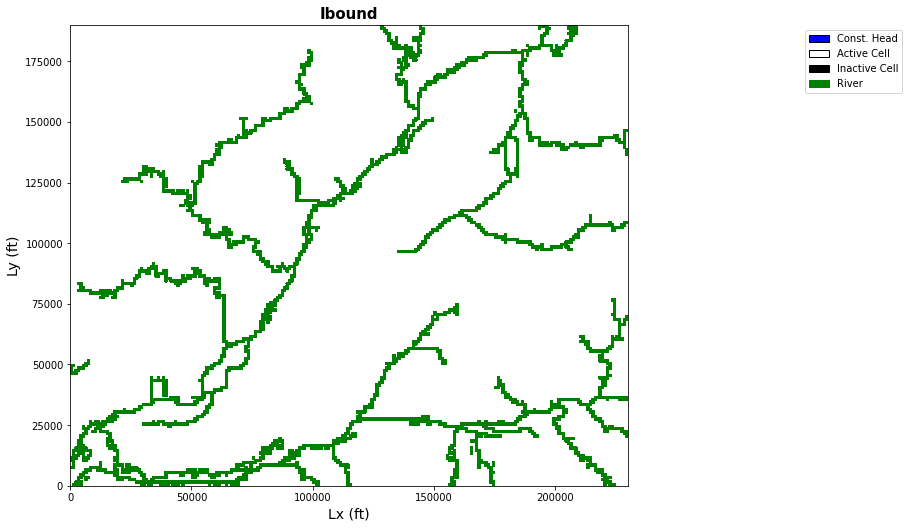

In [61]:
'''Plot grid and boundary conditions'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
#grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
rvr = modelmap.plot_bc(ftype='RIV')
#add labels and legend
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='green',label='River',ec='green')],
                   bbox_to_anchor=(1.5,1.0))
#----------------------------------------------------------------------------

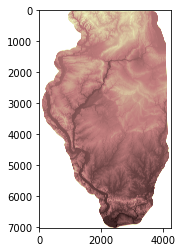

In [5]:
ildem = rasterio.open('dem_ill.tif')
elev = ildem.read(1)
elev = np.where(elev<0,400,elev)
plt.imshow(elev, cmap='pink')

In [7]:


# Define model domain in lat/long coordinates
ne_lat = 38.91667 #northeast latitude
ne_long = -89.91667 #northeast longitude

illimap = {'proj': 'lcc', # define projection as Lambert Conformal Conic
        'ellps': 'clrk66', # Use the Clarke 1866 ellipsoid
        'lon_0': -89.5, #Central Meridian
        'lat_0': 33, #Latitude of Origin
        'lat_1': 33, #Standard Parallel 1
        'lat_2': 45, #Standard Parallel 2
        'x_0': 2999994*0.3048006096012192, # starting x coordinate is in feet, Python expects meters
        'y_0': 0} # starting y coordinate}

wgs84 = pyproj.Proj("epsg:4326")

lamx,lamy = transform(wgs84,illimap,ne_lat,ne_long)

print(lamx*3.28,lamy*3.28)

newlat,newlong = pyproj.transform(illimap,wgs84,lamx,lamy)

print(newlat,newlong)



2881346.9553688564 2145845.98203598
38.91666999999978 -89.91667


In [11]:
from google.colab import files
files.upload()

Saving dem_ill.tfw to dem_ill.tfw
Saving dem_ill.tif to dem_ill.tif
Saving dem_ill.tif.aux.xml to dem_ill.tif.aux.xml
Saving dem_ill.tif.ovr to dem_ill.tif.ovr
Saving dem_ill.tif.vat.cpg to dem_ill.tif.vat.cpg
Saving dem_ill.tif.vat.dbf to dem_ill.tif.vat.dbf


In [15]:

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
